In [2]:
%load_ext autoreload
%autoreload 2


from text3d2video.generative_rendering.generative_rendering_pipeline import (
    DiffusionSpatialFeatures,
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
from matplotlib.cm import get_cmap

from visual_tests.testing_utils import test_img
import torchvision.transforms.functional as TF


layers = ["layer1", "layer2", "layer3"]
layer_resolutions = [16, 32, 64]
n_frames = 5

def make_test_spatial_features(
    layers: list[str], layer_resolutions: list[int], n_frames: int = 5
):
    features = DiffusionSpatialFeatures()

    cmap = get_cmap("tab10")
    frame_indices = torch.arange(n_frames)

    for i, layer in enumerate(layers):
        res = layer_resolutions[i]

        colors = cmap(frame_indices)

        images = [
            test_img(resolution=res, color=colors[i][0:3], txt=layer)
            for i in range(n_frames)
        ]
        feature_maps = torch.stack([TF.to_tensor(img) for img in images])
        feature_maps = feature_maps.unsqueeze(0).cuda()

        features.add_features(layer, feature_maps)

    return features

features = make_test_spatial_features(layers, layer_resolutions, n_frames=5)
features.shapes()

{'layer1': torch.Size([1, 5, 3, 16, 16]),
 'layer2': torch.Size([1, 5, 3, 32, 32]),
 'layer3': torch.Size([1, 5, 3, 64, 64])}

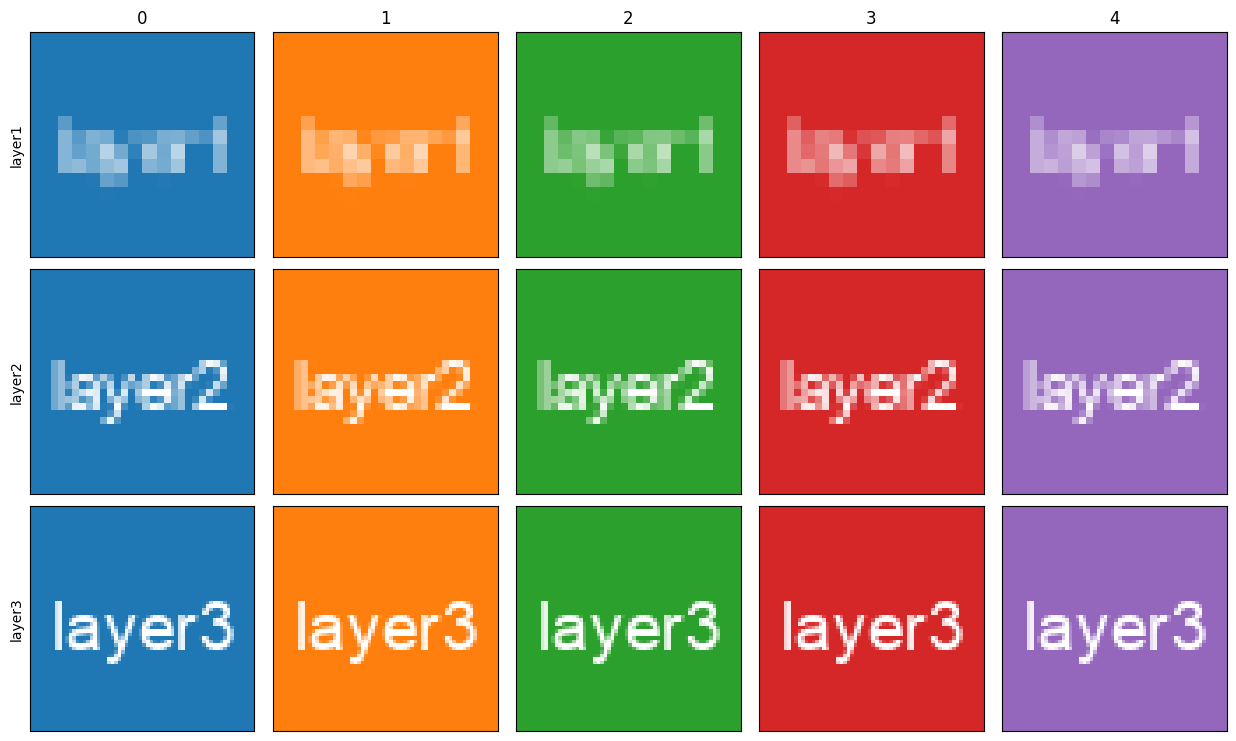

In [7]:
from text3d2video.ipython_utils import display_ims_grid

def show_spatial_features(features: DiffusionSpatialFeatures):
    n_frames = features.n_frames()

    images = []
    for layer in features.modules():
        layer_features = features.read_features(layer)[0]
        layer_ims = [TF.to_pil_image(layer_features[i]) for i in range(n_frames)]
        images.append(layer_ims)

    display_ims_grid(images, row_titles=features.modules(), col_titles=range(n_frames))

show_spatial_features(features)


In [8]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.util import project_visible_texels_to_cameras

animation = AnimationArtifact.from_wandb_artifact_tag('rumba:latest')
frame_indices = animation.frame_indices(n_frames)
cams, meshes = animation.load_frames(frame_indices)
verts_uvs, faces_uvs = animation.uv_data()

frame_xy_coords = []
frame_uv_coords = []

texture_res = 256

for mesh, cam in zip(meshes, cams):
    xy_coords, uv_coords = project_visible_texels_to_cameras(
        mesh,
        cam,
        verts_uvs,
        faces_uvs,
        texture_res=texture_res,
        render_resolution=1000,
    )
    torch.cuda.empty_cache()
    frame_xy_coords.append(xy_coords)
    frame_uv_coords.append(uv_coords)

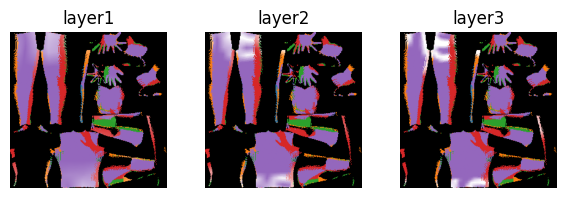

In [9]:
from text3d2video.generative_rendering.generative_rendering_pipeline import (
    DiffusionAggregatedUVMaps,
    aggregate_spatial_features,
)
from text3d2video.ipython_utils import display_ims

uvmaps = aggregate_spatial_features(
    features, texture_res, frame_xy_coords, frame_uv_coords, verts_uvs, faces_uvs
)


def show_aggregated_features(uvmaps: DiffusionAggregatedUVMaps):
    maps = torch.stack(
        [uvmaps.read_features(layer)[0] for layer in uvmaps.modules()]
    ).cpu()
    display_ims(maps, titles=uvmaps.modules())


show_aggregated_features(uvmaps)

In [138]:
tex = uvmaps.read_texture("layer1", 0)

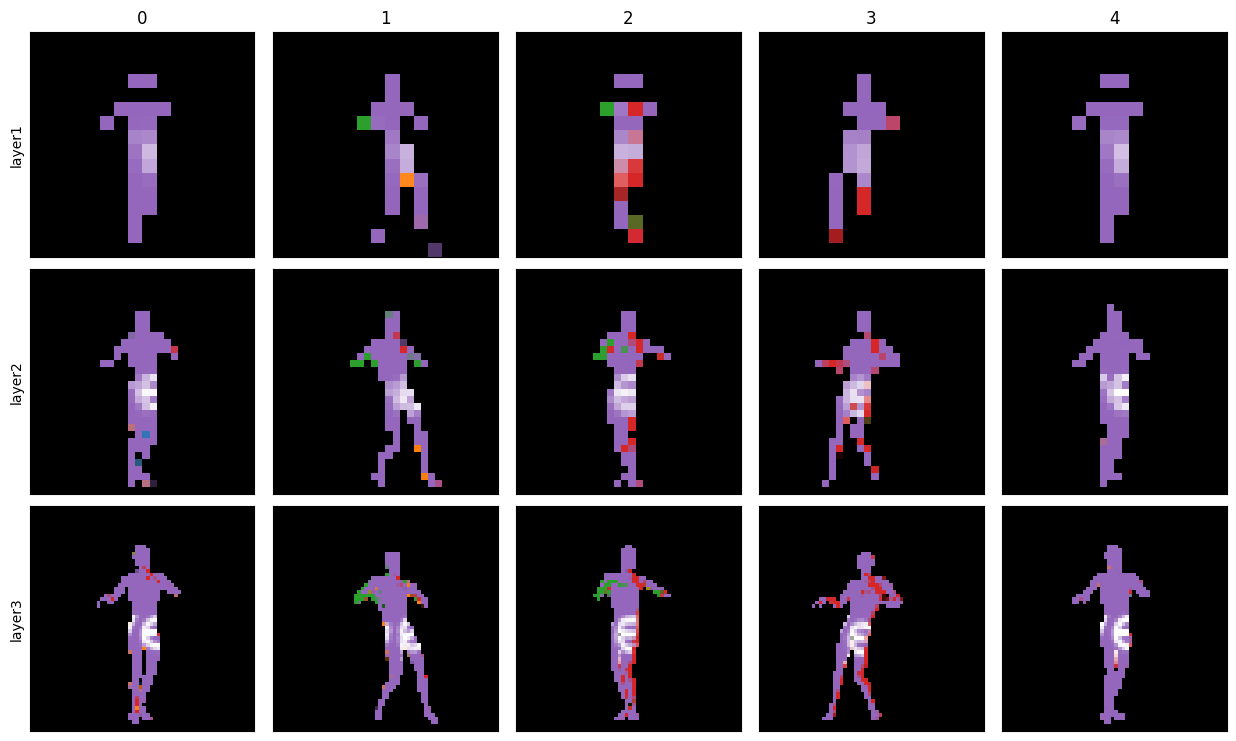

In [146]:
from text3d2video.generative_rendering.generative_rendering_pipeline import (
    render_feature_images,
)

rendered = render_feature_images(
    cams,
    meshes,
    uvmaps,
)

show_spatial_features(rendered)